## Imports

In [1]:
import os
import torch
import torch.nn as nn
import wandb
import numpy as np

from torchvision import transforms
from mmcv_csn import ResNet3dCSN
from cls_head import ClassifierHead
from cls_autoencoder import EncoderDecoder
from scheduler import GradualWarmupScheduler
from mmaction.datasets import build_dataset

/home/sadat/miniconda3/envs/dataloader/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sadat/miniconda3/envs/dataloader/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [8]:
os.chdir('../')

## Device Agnostic Code

In [2]:
try:
    device = 'mps' if torch.backends.mps.is_available() else 'cpu'
except:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'


## Dataset

In [123]:
train_cfg=dict(
    type='RawframeDataset',
    ann_file='data/wlasl/train_annotations.txt',
    data_prefix='data/wlasl/rawframes',
    pipeline=[
        dict(
            type='SampleFrames',
            clip_len=32,
            frame_interval=2,
            num_clips=1),
        dict(type='RawFrameDecode'),
        dict(type='Resize', scale=(-1, 256)),
        dict(type='RandomResizedCrop', area_range=(0.4,1.0)),
        dict(type='Resize', scale=(224, 224), keep_ratio=False),
        dict(type='Flip', flip_ratio=0.5),
        dict(
            type='Normalize',
            mean=[123.675, 116.28, 103.53],
            std=[58.395, 57.12, 57.375],
            to_bgr=False),
        dict(type='FormatShape', input_format='NCTHW'),
        dict(type='Collect', keys=['imgs', 'label'], meta_keys=[]),
        dict(type='ToTensor', keys=['imgs', 'label'])
    ])


test_cfg=dict(
        type='RawframeDataset',
        ann_file='data/wlasl/test_annotations.txt',
        data_prefix='data/wlasl/rawframes',
        pipeline=[
            dict(
                type='SampleFrames',
                clip_len=32,
                frame_interval=2,
                num_clips=1,
                test_mode=True),
            dict(type='RawFrameDecode'),
            dict(type='Resize', scale=(-1, 256)),
            dict(type='CenterCrop', crop_size=224),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_bgr=False),
            dict(type='FormatShape', input_format='NCTHW'),
            dict(type='Collect', keys=['imgs', 'label'], meta_keys=[]),
            dict(type='ToTensor', keys=['imgs'])
    ])

In [93]:
work_dir = 'work_dirs/wlasl-dataset/'
batch_size = 2

os.makedirs(work_dir, exist_ok=True)

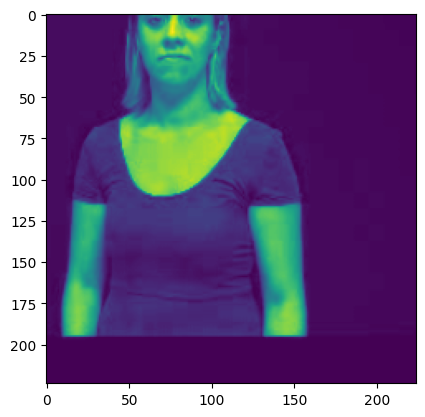

In [158]:
# Building the datasets
train_dataset = build_dataset(train_cfg)
test_dataset = build_dataset(test_cfg)

# Setting up dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    num_workers=4,
                                    pin_memory=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                    batch_size=1,
                                    shuffle=True,
                                    num_workers=4,
                                    pin_memory=True)

for x in train_loader:
    break
video=x['imgs']
plt.imshow(video[0][0][0][0])

In [21]:
for x in train_loader:
    break

In [12]:
import matplotlib.pyplot as plt

In [23]:
video=x['imgs']

In [25]:
video.shape

torch.Size([2, 1, 3, 32, 224, 224])

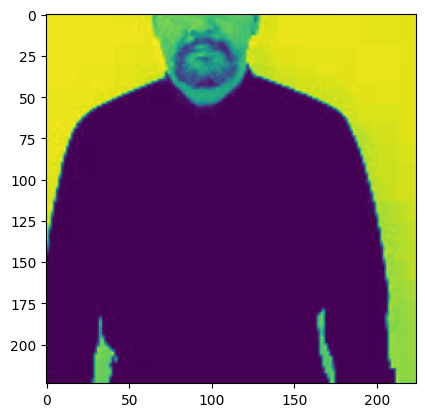

In [26]:
plt.imshow(video[0][0][0][0])

## Model

In [7]:
# Create a CSN model
encoder = ResNet3dCSN(
    pretrained2d=False,
    # pretrained=None,
    pretrained='https://download.openmmlab.com/mmaction/recognition/csn/ircsn_from_scratch_r50_ig65m_20210617-ce545a37.pth',
    depth=50,
    with_pool2=False,
    bottleneck_mode='ir',
    norm_eval=True,
    zero_init_residual=False,
    bn_frozen=True
)

encoder.init_weights()

reconstruct_head = RecontructionHead()

decoder = ClassifierHead(num_classes=400,
                 in_features=2048,
                 dropout_ratio=0.5,
                 init_std=0.01)

decoder.init_weights()

model = EncoderDecoder(encoder, decoder, reconstruct_head)

## Optimizer and Scheduler

In [8]:
# Specify Loss
loss_cls = nn.CrossEntropyLoss()
loss_reconstruct = nn.MSELoss()

# Specify optimizer
optimizer = torch.optim.SGD(
    model.parameters(), lr=0.0000125, momentum=0.9, weight_decay=0.00001)

# Specify learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=6, gamma=0.1)

scheduler = WarmUpScheduler(optimizer, lr_scheduler,
                            len_loader=len(train_loader),
                            warmup_steps=1,
                            warmup_start_lr=1e-6,
                            warmup_mode='linear')
# Setup wandb
# wandb.watch(model, log_freq=10)

## Helper Functions

In [9]:
def train_one_epoch(epoch_index, interval=5):
    """Run one epoch for training.
    Args:
        epoch_index (int): Current epoch.
        interval (int): Frequency at which to print logs.
    Returns:
        last_loss (float): Loss value for the last batch.
        learning_rate (float): Learning rate for the last batch.
    """
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, (images, targets) in enumerate(train_loader):
        # Every data instance is an input + label pair
        images, targets = images.to(device).permute(
            0, 2, 1, 3, 4), targets.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        cls_score, reconstructed = model(images)


        
        # Compute the loss and its gradients
        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(
            model.parameters(), max_norm=40, norm_type=2)

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % interval == interval-1:
            last_loss = running_loss / interval  # loss per batch
            top1_acc = loss_results['top1_acc']
            top5_acc = loss_results['top5_acc']
            print(
                f'Epoch [{epoch_index}][{i+1}/{len(train_loader)}], lr: {scheduler.get_last_lr()[0]:.5e}, loss: {last_loss:.5}, top1_acc: {top1_acc}, top5_acc: {top5_acc}')
            running_loss = 0.

    return last_loss, scheduler.get_last_lr()[0]


def validate():
    """Run one epoch for validation.
    Returns:
        avg_vloss (float): Validation loss value for the last batch.
        top1_acc (float): Top-1 accuracy in decimal.
        top5_acc (float): Top-5 accuracy in decimal.
    """
    running_vloss = 0.
    print('Evaluating top_k_accuracy...')

    with torch.inference_mode():
        for i, (vimages, vtargets) in enumerate(test_loader):
            vimages, vtargets = vimages.to(device), vtargets.to(device)

            voutputs = model(vimages.permute(0, 2, 1, 3, 4))
            # Get losses
            loss_cls_score = loss_cls(cls_score, targets)
            loss_reconstruct_score = loss_reconstruct(reconstructed, images)
            vloss = 0.8 * loss_cls_score + 0.2 * loss_reconstruct_score

            running_vloss += vloss


    avg_vloss = running_vloss / (i + 1)
    top1_acc = loss_results['top1_acc']
    top5_acc = loss_results['top5_acc']

    return (avg_vloss, top1_acc, top5_acc)

## Train Loop

In [10]:
# Train Loop
epochs = 58
best_vloss = 1_000_000.

# Transfer model to device
model.to(device)

for epoch in range(epochs):
    # Adjust learning rate
    scheduler.step()

    # Turn on gradient tracking and do a forward pass
    model.train(True)
    avg_loss, learning_rate = train_one_epoch(epoch+1)

    # Turn off  gradients for reporting
    model.train(False)

    avg_vloss, top1_acc, top5_acc = validate()

    print(
        f'top1_acc: {top1_acc:.4}, top5_acc: {top5_acc:.4}, train_loss: {avg_loss:.5}, val_loss: {avg_vloss:.5}')

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = work_dir + f'epoch_{epoch+1}.pth'
        print(f'Saving checkpoint at {epoch+1} epochs...')
        torch.save(model.state_dict(), model_path)

    # Track wandb
    wandb.log({'train/loss': avg_loss,
               'train/learning_rate': learning_rate,
               'val/loss': avg_vloss,
               'val/top1_accuracy': top1_acc,
               'val/top5_accuracy': top5_acc})

IndexError: index 1 is out of bounds for dimension 0 with size 1